# READING DATA

1. Import Dependencies
2. Read Data and create dataframe
3. Get test profiles from test-classification-round1.dat
4. Get training data from training-classification.csv
5. Remove the profiles in test-classification-round1.dat from the training data and add them to intersection test set.(Will be used later for testing)


1. Import Dependencies

In [52]:
import numpy as np
import pandas as pd
import gzip
import json


2. Read data and create df

In [53]:
train_classification_df = pd.read_csv("train-classification.csv")
train_classification_df = train_classification_df.rename(columns={"Unnamed: 0": "username", "label": "influencerCategory"})
train_classification_df['influencerCategory'] = train_classification_df['influencerCategory'].apply(str.lower)
train_classification_df.head()

,username,influencerCategory
0,taskirancemal,mom and children
1,tam_kararinda,food
2,spart4nn,food
3,sosyalyiyiciler,food
4,sonaydizdarahad,mom and children


In [54]:
print(train_classification_df.head())
print(train_classification_df.shape)

          username influencerCategory
0    taskirancemal   mom and children
1    tam_kararinda               food
2         spart4nn               food
3  sosyalyiyiciler               food
4  sonaydizdarahad   mom and children
(2742, 2)


In [55]:
train_classification_df.groupby('influencerCategory').count()

,username
influencerCategory,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [56]:
username2category = train_classification_df.set_index('username')['influencerCategory'].to_dict()
username2category

{'taskirancemal': 'mom and children',
 'tam_kararinda': 'food',
 'spart4nn': 'food',
 'sosyalyiyiciler': 'food',
 'sonaydizdarahad': 'mom and children',
 'somersivrioglu': 'food',
 'sinankoc': 'travel',
 'simulasyonturk': 'gaming',
 'savas_karakas_sudaki_izler': 'travel',
 'sakinenurunannesi': 'mom and children',
 'ruyabuyuktetik': 'fashion',
 'raykakumru': 'health and lifestyle',
 'pintipanda': 'gaming',
 'pinarindepresyonu': 'health and lifestyle',
 'pinarhotic': 'health and lifestyle',
 'pinardonmez_': 'mom and children',
 'ozgeninoltasi': 'food',
 'nayaozgun': 'fashion',
 'nataliyarcan': 'health and lifestyle',
 'muthispsikoloji': 'health and lifestyle',
 'murattekecicom': 'tech',
 'mrsisbeceren': 'mom and children',
 'mosyosokola': 'food',
 'mirandaorlayn': 'entertainment',
 'mezarci_pubg': 'gaming',
 'mervedemireltaskiran': 'travel',
 'lifewithapineapple': 'travel',
 'lalsefkatli': 'travel',
 'kutupanne': 'mom and children',
 'kosifcihan': 'health and lifestyle',
 'kisikatescom':

In [57]:
username2profile_train = dict()
username2posts_train = dict()

username2profile_test = dict()
username2posts_test = dict()


3. Get test profiles from test-classification-round1.dat

In [58]:
test_usernames = []
with open('test-classification-round3.dat', 'r') as f:
    for line in f:
        test_usernames.append(line.strip())

len(test_usernames)

1000

4. Get training data from training-classification.csv

In [59]:
with gzip.open('training-dataset.jsonl.gz', 'rt') as f:
    for line in f:
        sample = json.loads(line)

        profile = sample['profile']
        username = profile['username']


        if username in username2category:
            username2profile_train[username] = profile
            username2posts_train[username] = sample['posts']
            
        if username in test_usernames:
            username2profile_test[username] = profile
            username2posts_test[username] = sample['posts']

In [60]:
len(username2profile_train), len(username2profile_test)

(2741, 1000)

# DATA PREPROCESSING

1. Import nltk

In [61]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beratkaratasoglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
len(turkish_stopwords)

53

2. define text proeprocessing function

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from snowballstemmer import TurkishStemmer

stemmer = TurkishStemmer()

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    if text != "":
      words = text.split()
      stemed = [stemmer.stemWord(word) for word in words]
      text = " ".join(stemed)
    

    return text




3. Add post captions as a feature

In [64]:
trainingData = pd.DataFrame(username2profile_train).T.reset_index()
trainingData.drop(columns=['index'], inplace=True)

testingData = pd.DataFrame(username2profile_test).T.reset_index()
testingData.drop(columns=['index'], inplace=True)



for index, row in trainingData.iterrows():
    if row['username'] in username2category:
        trainingData.at[index, 'influencerCategory'] = username2category[row['username']]


    captions = ""
    totalLikes = 0
    postCount = 0
    for post in username2posts_train[row['username']]:
        if post.get('caption') is not None:
            captions = "\n".join([captions, post['caption']])
        else:    
            captions = "\n".join([captions, ""])
        
        if post.get('like_count') is not None:
            totalLikes += post['like_count']
        if post.get('like_count') is None:
            totalLikes += 0
        postCount += 1

    if postCount == 0:
        avgLikes = 0
    else:
        avgLikes = totalLikes / postCount
    trainingData.at[index, 'avg_likes'] = avgLikes
    trainingData.at[index, 'captions'] = captions



for index, row in testingData.iterrows():
    captions = ""
    totalLikes = 0
    postCount = 0
    for post in username2posts_test[row['username']]:
        if post.get('caption') is not None:
            captions = "\n".join([captions, post['caption']])
        else:    
            captions = "\n".join([captions, ""])
        
        if post.get('like_count') is not None:
            totalLikes += post['like_count']
        if post.get('like_count') is None:
            totalLikes += 0
        postCount += 1

    if postCount == 0:
        avgLikes = 0
    else:
        avgLikes = totalLikes / postCount
    testingData.at[index, 'avg_likes'] = avgLikes
    testingData.at[index, 'captions'] = captions



In [65]:
trainingData.isnull().sum()

username                                0
id                                      0
full_name                              26
biography                             170
category_name                         515
post_count                           2466
follower_count                          0
following_count                         0
is_business_account                     0
is_private                              0
is_verified                             0
highlight_reel_count                    0
bio_links                               0
entities                              170
ai_agent_type                        2741
fb_profile_biolink                   2741
restricted_by_viewer                 2741
country_block                           0
eimu_id                                 0
external_url                          457
fbid                                    0
has_clips                               0
hide_like_and_view_counts               0
is_professional_account           

In [66]:
trainingData['biography'].fillna("", inplace=True)
trainingData['full_name'].fillna("", inplace=True)
trainingData['external_url'].fillna("", inplace=True)
trainingData['category_name'].fillna("", inplace=True)


/var/folders/fg/9flc738d345c3sdd8tq2cln80000gn/T/ipykernel_53787/1208481607.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainingData['biography'].fillna("", inplace=True)
/var/folders/fg/9flc738d345c3sdd8tq2cln80000gn/T/ipykernel_53787/1208481607.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [67]:
trainingData['text_merged'] = trainingData['username'] + " " + trainingData['category_name'] + " " +  trainingData['external_url'] + " " +  trainingData['full_name']+ " " +  trainingData['biography'] + " " + trainingData['captions']

In [68]:
trainingData['text_merged'].isnull().sum()

0

In [69]:
testingData['biography'].fillna("", inplace=True)
testingData['full_name'].fillna("", inplace=True)
testingData['external_url'].fillna("", inplace=True)
testingData['category_name'].fillna("", inplace=True)


/var/folders/fg/9flc738d345c3sdd8tq2cln80000gn/T/ipykernel_53787/3151778470.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testingData['biography'].fillna("", inplace=True)
/var/folders/fg/9flc738d345c3sdd8tq2cln80000gn/T/ipykernel_53787/3151778470.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [70]:
testingData['text_merged'] = testingData['username'] + " " + testingData['category_name'] + " " +  testingData['external_url'] + " " +  testingData['full_name']+ " " +  testingData['biography'] + " " + testingData['captions']

In [71]:
trainingData.groupby('influencerCategory')['avg_likes'].mean()

influencerCategory
art                     12940.601187
entertainment           15540.530558
fashion                  6617.994026
food                     1142.289658
gaming                  33152.015385
health and lifestyle     3027.769666
mom and children         7699.645045
sports                  19471.062995
tech                      402.458947
travel                   2023.480766
Name: avg_likes, dtype: float64

In [72]:
trainingData.columns

Index(['username', 'id', 'full_name', 'biography', 'category_name',
       'post_count', 'follower_count', 'following_count',
       'is_business_account', 'is_private', 'is_verified',
       'highlight_reel_count', 'bio_links', 'entities', 'ai_agent_type',
       'fb_profile_biolink', 'restricted_by_viewer', 'country_block',
       'eimu_id', 'external_url', 'fbid', 'has_clips',
       'hide_like_and_view_counts', 'is_professional_account',
       'is_supervision_enabled', 'is_guardian_of_viewer',
       'is_supervised_by_viewer', 'is_supervised_user', 'is_embeds_disabled',
       'is_joined_recently', 'business_address_json',
       'business_contact_method', 'business_email', 'business_phone_number',
       'business_category_name', 'overall_category_name', 'category_enum',
       'is_verified_by_mv4b', 'is_regulated_c18', 'profile_pic_url',
       'should_show_category', 'should_show_public_contacts',
       'show_account_transparency_details', 'profile_picture_base64',
       'inf

In [73]:
trainingData.groupby('influencerCategory').agg({'follower_count': 'mean', 
                                                'following_count': 'mean', 
                                                'highlight_reel_count': 'mean', 
                                                'post_count': 'mean', 
                                                'is_verified': 'mean',
                                                'is_business_account': 'mean',
                                                'is_joined_recently': 'mean',
                                                'is_professional_account': 'mean',
                                                })

,follower_count,following_count,highlight_reel_count,post_count,is_verified,is_business_account,is_joined_recently,is_professional_account
influencerCategory,,,,,,,,
art,366018.418848,701.17801,14.204188,1662.888889,0.282723,0.612565,0.0,1.0
entertainment,462118.578947,461.650155,10.551084,1291.184211,0.352941,0.578947,0.0,0.993808
fashion,1528197.501672,551.662207,19.394649,2236.326087,0.280936,0.705686,0.0,1.0
food,65362.142857,412.227006,12.878669,2280.857143,0.127202,0.786693,0.0,1.0
gaming,273858.0,323.153846,8.384615,358.0,0.461538,0.384615,0.0,1.0
health and lifestyle,119645.482072,544.611554,13.776892,1599.657895,0.262948,0.739044,0.0,1.0
mom and children,215094.738255,640.114094,16.154362,1713.241379,0.308725,0.610738,0.0,1.0
sports,412026.371681,520.353982,8.938053,1699.916667,0.460177,0.59292,0.0,1.0
tech,31893.557803,260.343931,7.734104,2214.0,0.112717,0.881503,0.0,1.0


4. Set Feature columns and create train and test sets.

In [74]:
feature_columns = ['avg_likes', 'follower_count', 'following_count', 'highlight_reel_count', 'is_business_account', 'text_merged']

In [75]:
trainingData[trainingData['influencerCategory'].isnull() > 0]
trainingData.dropna(subset=['influencerCategory'], inplace=True)

In [76]:
trainingData['text_merged']

0       deparmedya Local business http://www.deparmedy...
1       kafesfirin Brand http://www.kafesfirin.com/ KA...
2       vimerang  http://vimerang.com/ Vimerang Dijita...
3       mustafa_yalcinn38 Politician http://www.talas....
4       zorluenergysolutions  https://bit.ly/zeswikipe...
                              ...                        
2736    tatlidunyasidergisi Product/service https://ww...
2737    yerindengelsin.com.tr Shopping & retail http:/...
2738    woodtechistanbul Event https://www.woodtechist...
2739    netsvadi  https://www.netsclub.com.tr/tr/detok...
2740    herbisiatolye Health/beauty http://www.herbisi...
Name: text_merged, Length: 2741, dtype: object

In [77]:
trainingData['text_merged'] = trainingData['text_merged'].apply(preprocess_text)
testingData['text_merged'] = testingData['text_merged'].apply(preprocess_text)

In [78]:
X_train = trainingData[feature_columns].reset_index(drop=True)
Y_train = trainingData['influencerCategory'].reset_index(drop=True)

X_test = testingData[feature_columns].reset_index(drop=True)


In [79]:
Y_train.value_counts()

influencerCategory
food                    511
health and lifestyle    502
tech                    346
entertainment           323
fashion                 299
travel                  294
art                     191
mom and children        149
sports                  113
gaming                   13
Name: count, dtype: int64

In [80]:
X_train.head()

,avg_likes,follower_count,following_count,highlight_reel_count,is_business_account,text_merged
0,11.542857,1167,192,6,True,deparmedya local business depar medya #mediapl...
1,31.514286,11997,17,15,True,kafesfir brand kafes fir sogutozuftz avm ankar...
2,233.885714,2321,454,11,True,vimerangı vimerangı dijital iletiş yönetimiinf...
3,361.342857,13647,29,2,True,mustafayalcinn politician mustaf yalç talas be...
4,72.800000,7917,11,7,True,zorluenergysolutions zes zorlu energy solution...


In [81]:
X_train.shape, Y_train.shape, X_test.shape


((2741, 6), (2741,), (1000, 6))

5. Fill Missing Values

In [82]:
X_train.isnull().sum()

avg_likes               0
follower_count          0
following_count         0
highlight_reel_count    0
is_business_account     0
text_merged             0
dtype: int64

In [83]:

X_train['is_business_account'] = X_train['is_business_account'].astype(int)

X_test['is_business_account'] = X_test['is_business_account'].astype(int)


6. Scale numerical values

In [84]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

numeric_features = ['follower_count', 'following_count', 'is_business_account', 'highlight_reel_count', 'avg_likes']
text_features = ['text_merged']

scaler = StandardScaler()

X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

# Drop numeric features from X_train to prevent duplicates
X_train.drop(columns=numeric_features, inplace=True, errors='ignore')
X_test.drop(columns=numeric_features, inplace=True, errors='ignore')


X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_features)
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_features)

X_train_numeric.index = X_train.index
X_test_numeric.index = X_test.index


X_train = pd.concat([X_train, X_train_numeric], axis=1)
X_test = pd.concat([X_test, X_test_numeric], axis=1)

X_train.shape, X_test.shape

((2741, 6), (1000, 6))

7. Apply tfid vectorizer

In [85]:
X_train.head()

,text_merged,follower_count,following_count,is_business_account,highlight_reel_count,avg_likes
0,deparmedya local business depar medya #mediapl...,-0.052662,-0.301925,0.624467,-0.232669,-0.169928
1,kafesfir brand kafes fir sogutozuftz avm ankar...,-0.050889,-0.486279,0.624467,0.069278,-0.169349
2,vimerangı vimerangı dijital iletiş yönetimiinf...,-0.052473,-0.025919,0.624467,-0.064921,-0.163478
3,mustafayalcinn politician mustaf yalç talas be...,-0.050619,-0.473638,0.624467,-0.366867,-0.159780
4,zorluenergysolutions zes zorlu energy solution...,-0.051557,-0.492600,0.624467,-0.199119,-0.168151


In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000, ngram_range=(1, 2))



X_train['text_merged'] = X_train['text_merged'].astype(str)
X_test['text_merged'] = X_test['text_merged'].astype(str)

tfidf_train = vectorizer.fit_transform(X_train['text_merged'])
tfidf_test = vectorizer.transform(X_test['text_merged'])

X_train.drop(columns=text_features, inplace=True)
X_test.drop(columns=text_features, inplace=True)

X_train = pd.concat([X_train, pd.DataFrame(tfidf_train.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(tfidf_test.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)


print(f"X_train_final shape: {X_train.shape}")
print(f"X_test_final shape: {X_test.shape}")




X_train_final shape: (2741, 5005)
X_test_final shape: (1000, 5005)


In [87]:
X_train.shape

(2741, 5005)

8. Split training sets to create validation sets

In [88]:
Y_train = trainingData['influencerCategory'].reset_index(drop=True)

In [89]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)



In [90]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable if necessary
encoder = LabelEncoder()
y_train_en = encoder.fit_transform(y_train)
y_val_en = encoder.transform(y_val)


labels = encoder.classes_
labels



array(['art', 'entertainment', 'fashion', 'food', 'gaming',
       'health and lifestyle', 'mom and children', 'sports', 'tech',
       'travel'], dtype=object)

In [91]:
y_train_en.shape

(2192,)

In [92]:
y_val.value_counts()

influencerCategory
food                    114
health and lifestyle     96
travel                   62
tech                     59
entertainment            59
fashion                  55
art                      38
mom and children         34
sports                   27
gaming                    5
Name: count, dtype: int64

In [93]:
x_train.head()

,follower_count,following_count,is_business_account,highlight_reel_count,avg_likes,abdullah,abi,abone,about,acap,...,şube,şubes,şö,şöle,şükra,şükran,şükür,şık,şık bir,şıklık
662,-0.052129,-0.392522,0.624467,-0.232669,-0.168652,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.020243,0.0,0.0,0.000000,0.000000,0.00000
1973,-0.050781,4.218457,0.624467,-0.266218,-0.168342,0.0,0.0,0.0,0.010177,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000
1608,0.305142,-0.390415,-1.601365,-0.098470,1.684158,0.0,0.0,0.0,0.022298,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000
1859,-0.047516,0.266942,0.624467,-0.098470,-0.167384,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013974,0.000000,0.00000
1532,-0.021057,-0.498921,0.624467,0.136377,-0.167974,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.053149,0.025962,0.04026


# SUPPORT VECTOR MACHINE MODEL FOR CLASSIFICATION

SVM Accuracy: 0.6757741347905283

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.42      0.43        38
           1       0.47      0.46      0.46        59
           2       0.59      0.78      0.67        55
           3       0.90      0.83      0.87       114
           4       0.00      0.00      0.00         5
           5       0.75      0.61      0.67        96
           6       0.67      0.47      0.55        34
           7       0.81      0.78      0.79        27
           8       0.61      0.83      0.71        59
           9       0.67      0.73      0.70        62

    accuracy                           0.68       549
   macro avg       0.59      0.59      0.59       549
weighted avg       0.68      0.68      0.67       549



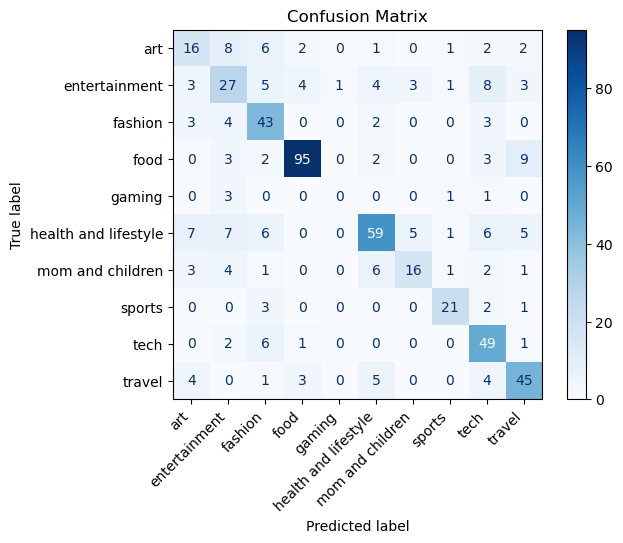

In [94]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize SVM with RBF kernel
svm_model = SVC(kernel='linear', C=1, class_weight='balanced', gamma='scale', random_state=42)

# Train the model
svm_model.fit(x_train, y_train_en)

# Predict on the test set
y_pred = svm_model.predict(x_val)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_val_en, y_pred))
print("\nClassification Report:\n", classification_report(y_val_en, y_pred))

# Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_val_en, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix")
plt.show()

# WRITE RESULTS FOR TEST PROFILES IN JSON FILE

In [45]:
test_pred = svm_model.predict(X_test)
test_pred

test_pred = encoder.inverse_transform(test_pred)
test_pred

array(['tech', 'health and lifestyle', 'health and lifestyle',
       'entertainment', 'food', 'travel', 'entertainment', 'food', 'food',
       'tech', 'health and lifestyle', 'food', 'food', 'fashion',
       'fashion', 'tech', 'tech', 'food', 'travel', 'tech',
       'health and lifestyle', 'fashion', 'entertainment', 'food',
       'entertainment', 'sports', 'entertainment', 'tech',
       'entertainment', 'art', 'entertainment', 'tech',
       'health and lifestyle', 'tech', 'health and lifestyle',
       'entertainment', 'tech', 'travel', 'health and lifestyle', 'tech',
       'art', 'entertainment', 'health and lifestyle', 'fashion', 'food',
       'health and lifestyle', 'fashion', 'food', 'food',
       'health and lifestyle', 'entertainment', 'food', 'fashion',
       'entertainment', 'fashion', 'food', 'tech', 'food', 'food', 'art',
       'health and lifestyle', 'fashion', 'health and lifestyle',
       'health and lifestyle', 'health and lifestyle', 'tech',
       'health 

In [46]:
X_test['influencerCategory'] = test_pred

In [47]:
testingData['influencerCategory'] = test_pred

In [48]:
testingData[['username','influencerCategory']] 

,username,influencerCategory
0,vimerang,tech
1,drtubagunebak,health and lifestyle
2,nihatcan11,health and lifestyle
3,mtmofamily,entertainment
4,yudumyag,food
...,...,...
995,muzegazhane,art
996,tiyatroboyalikus,art
997,bs_forklift,tech
998,nestleturkiye,health and lifestyle


In [49]:
output = dict()

for index, row in testingData.iterrows():
    output[row['username']] = row['influencerCategory']
    

In [50]:
with open('berat-test-classification-round3-output.json', 'w') as f:
    json.dump(output, f, indent=4)

In [51]:
testingData['influencerCategory'].value_counts()

influencerCategory
health and lifestyle    206
entertainment           164
tech                    135
food                    118
art                     112
fashion                 110
travel                   86
mom and children         35
sports                   32
gaming                    2
Name: count, dtype: int64